## Importing Libraries

In [ ]:
#tensorflow and keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.callbacks import EarlyStopping

#sklearn libraries for data splitting, encoding and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

#matplotlib for plotting charts
import matplotlib.pyplot as plt
%matplotlib inline

#other libraries 
import numpy as np
import pandas as pd
from tkinter import Tcl
from google.colab.patches import cv2_imshow
import cv2,glob

## Mounting gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the annotaion files

In [ ]:
#Loading the annotations.csv
labels_df = pd.read_csv('/content/drive/MyDrive/annotations.csv', index_col=0)
not_human = []
for index, row in labels_df.iterrows():
  if(row['face not shown/not human'] == 1):
    not_human.append(index)
    labels_df.drop(index, inplace=True)
labels_df.head()

wrinkles  freakles  ...  hair_top  face not shown/not human
image_name                      ...                                    
129.jpg            1         0  ...         1                         0
155.jpg            1         0  ...         2                         0
184.jpg            0         1  ...         2                         0
293.jpg            1         0  ...         2                         0
361.jpg            0         1  ...         1                         0

[5 rows x 6 columns]

In [ ]:
#Loading the annotations1.csv
labels_df1 = pd.read_csv('/content/drive/MyDrive/annotations1.csv',index_col=0)
not_human1 = []
for index, row in labels_df1.iterrows():
  if(row['face not shown/not human'] == 1):
    not_human1.append(index)
    labels_df1.drop(index, inplace=True)
labels_df1.head()

wrinkles  freakles  ...  hair_top  face not shown/not human
image_name                               ...                                    
emotionet_3_18.jpg          0         1  ...         2                         0
emotionet_3_241.jpg         0         0  ...         2                         0
emotionet_3_290.jpg         0         0  ...         2                         0
emotionet_3_297.jpg         0         1  ...         2                         0
emotionet_3_319.jpg         0         1  ...         2                         0

[5 rows x 6 columns]

## Uploading the images and Resizing them to (200 x 200 x 3) size.

In [ ]:
items = glob.glob('/content/drive/MyDrive/images/*')

#sorting the images by name so that they have one to one correspondance with annotations.csv
items = Tcl().call('lsort', '-dict', items)

# Removing the non human images
items_sorted = []
for item in items:
  item = item.split('/')[-1]
  if(item not in not_human):
    items_sorted.append('/content/drive/MyDrive/images/' + item)

#Resizing the images to 200 x 200 x 3
all_images = []
for each_image in items_sorted:
  image = cv2.imread(each_image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (200, 200))
  all_images.append(image)

images_df = np.array(all_images)
images_df.shape

(1810, 200, 200, 3)

## Uploading the additional images and Resizing them to (200 x 200 x 3) size.

In [ ]:
items1 = glob.glob('/content/drive/MyDrive/images1/*')

#sorting the images by name so that they have one to one correspondance with annotations.csv
items1 = Tcl().call('lsort', '-dict', items1)

# Removing the non human images
items_sorted1 = []
for item in items1:
  item = item.split('/')[-1]
  if(item not in not_human1):
    items_sorted1.append('/content/drive/MyDrive/images1/' + item)

#Resizing the images to 200 x 200 x 3
all_images1 = []
for each_image in items_sorted1:
  image = cv2.imread(each_image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (200, 200))
  all_images1.append(image)

images_df1 = np.array(all_images1)
images_df1.shape

(1913, 200, 200, 3)

# Model 3 - glasses

## Combining images & labels

In [ ]:
df_glasses = pd.DataFrame()
df_glasses['images'] = all_images
labels = labels_df['glasses'].copy()
df_glasses['labels'] = labels.values

df_glasses1 = pd.DataFrame()
df_glasses1['images'] = all_images1
labels1 = labels_df1['glasses'].copy()
df_glasses1['labels'] = labels1.values

In [ ]:
#Count of classes (0- no glasses, 1 - plain glasses, 2 - sun glasses)
df = df_glasses.append(df_glasses1)
df['labels'].value_counts()

0    3342
1     323
2      58
Name: labels, dtype: int64

## Data Balancing - Over Sampling the classes that has less data



In [ ]:
df_noglasses = df[df['labels']==0]
df_plainglasses = df[df['labels']==1]
df_sunglasses = df[df['labels']==2]

df_sampling_glasses = pd.DataFrame(df_noglasses.iloc[:2000,:])
for i in range(6):
  df_sampling_glasses = df_sampling_glasses.append(df_plainglasses)
for i in range(25):
  df_sampling_glasses = df_sampling_glasses.append(df_sunglasses)

In [ ]:
#Count of classes after over sampling - Data balancing
df_sampling_glasses['labels'].value_counts()

0    2000
1    1938
2    1450
Name: labels, dtype: int64

In [ ]:
#Converting the input and output features as ndarray
X = np.array(df_sampling_glasses['images'])
y = np.array(df_sampling_glasses['labels'])
a =[]
for i in range(len(X)):
  a.append(X[i])
X = np.array(a)
X.shape

(5388, 200, 200, 3)

## Data samples before and after balancing

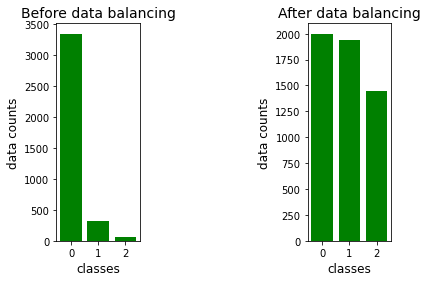

In [ ]:
plt.subplot(1, 2, 1)
plt.bar(df['labels'].value_counts().index,df['labels'].value_counts(), align='center',  color = 'green')
plt.xticks([0, 1, 2])
plt.xlabel('classes', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('Before data balancing', fontsize=14)
plt.subplots_adjust(wspace = 1.5, hspace = 1.5)

plt.subplot(1, 2, 2)
plt.bar(df_sampling_glasses['labels'].value_counts().index,df_sampling_glasses['labels'].value_counts(), align='center',  color = 'green')
plt.xticks([0, 1, 2])
plt.xlabel('classes', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('After data balancing', fontsize=14)
plt.subplots_adjust(wspace = 2, hspace = 2)

plt.show()

## Label Encoding

In [ ]:
y_encode = LabelEncoder()
y = y_encode.fit_transform(y)

## Split train and test images



In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=100, stratify=y)

In [ ]:
print(f'Shape of the training data: {train_images.shape}')
print(f'Shape of the training target: {train_labels.shape}')
print(f'Shape of the test data: {test_images.shape}')
print(f'Shape of the test target: {test_labels.shape}')

Shape of the training data: (3232, 200, 200, 3)
Shape of the training target: (3232,)
Shape of the test data: (2156, 200, 200, 3)
Shape of the test target: (2156,)


In [ ]:
#Count of the classes in training dataset
np.unique(train_labels, return_counts=True)

(array([0, 1, 2]), array([1200, 1162,  870]))

In [ ]:
#Count of the classes in testing dataset
np.unique(test_labels, return_counts=True)

(array([0, 1, 2]), array([800, 776, 580]))

## Verify few images from training set

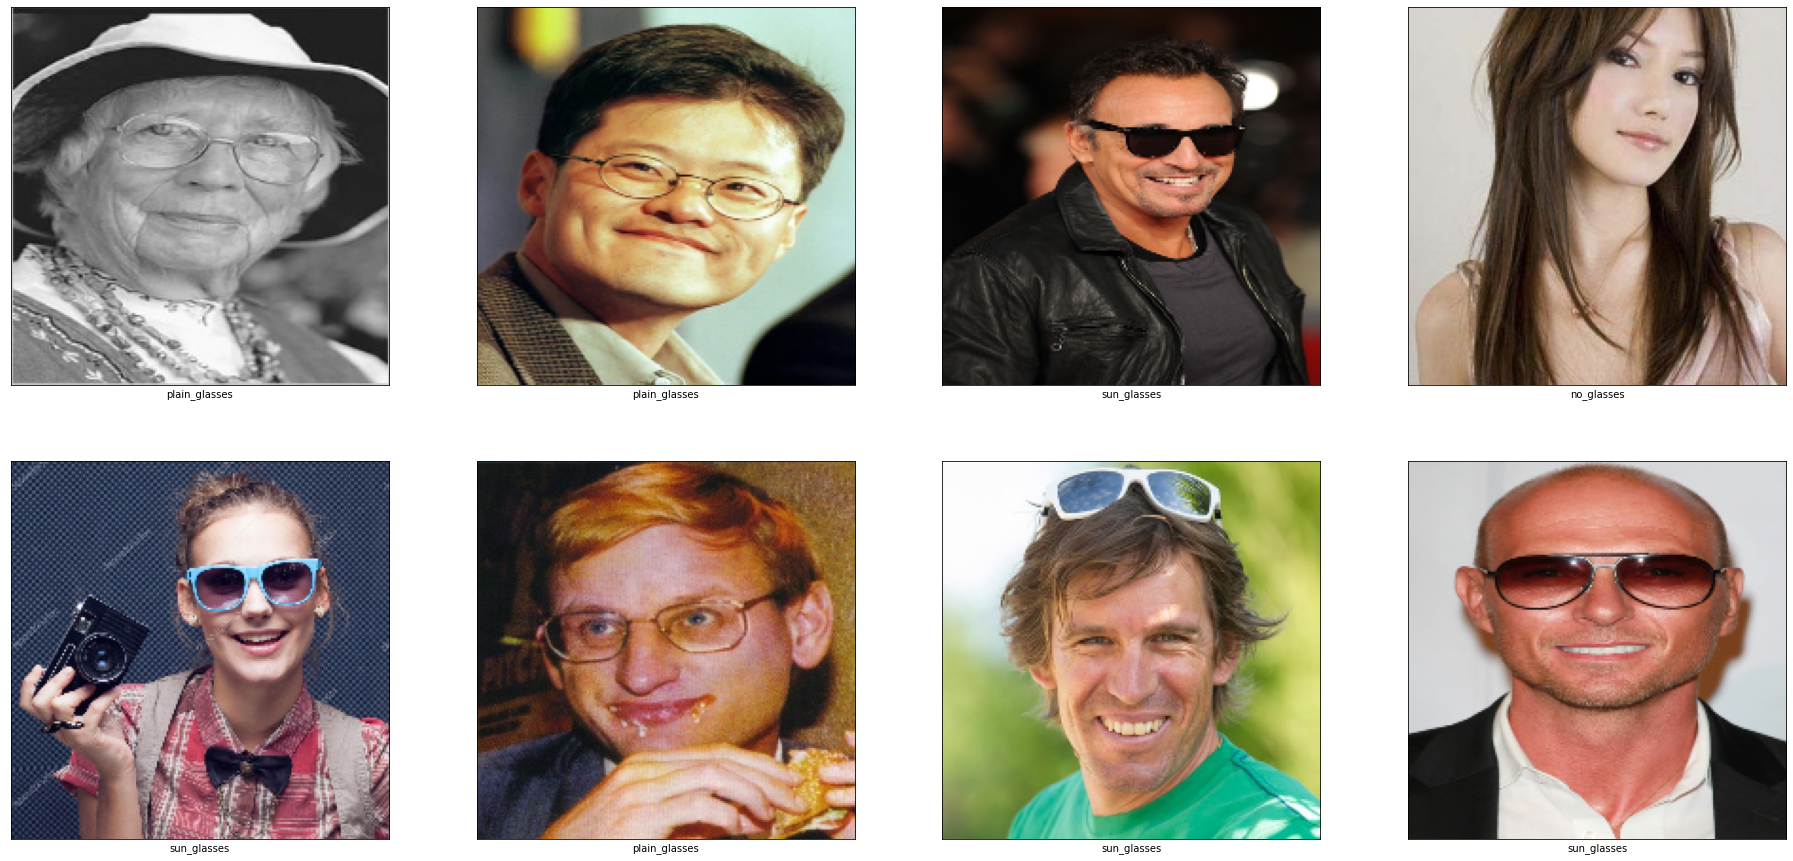

In [ ]:
# To verify if the dataset is correct and labels are matching the images
class_names = ['no_glasses', 'plain_glasses', 'sun_glasses']

plt.figure(figsize=(32,32))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Normalization of images

In [ ]:
train_images, test_images = train_images / 255.0, test_images / 255.0

## Using DenseNet and train the model

In [ ]:
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
        preprocessing.RandomContrast([0.1, 0.5])
    ]
)
input_shape = (200, 200, 3)
inputs = keras.Input(shape=input_shape)

# Augment images
x = data_augmentation(inputs)

model3 = keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=input_shape)(x)

# adding output layers
flat1 = layers.Flatten()(model3)
outputs = layers.Dense(3, activation='softmax')(flat1)

# define new model
model3 = Model(inputs=inputs, outputs= outputs)

model3.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model3.summary()

51879936/51877672 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 59904)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 179715    
Total params: 12,822,595
Trainable params: 12,664,195
Non-trainable params: 158,400
_________________________________________________________________


## Training

Epoch 1/5
51/51 [==============================] - 46s 523ms/step - loss: 0.6858 - accuracy: 0.7358 - val_loss: 0.1288 - val_accuracy: 0.9583
Epoch 2/5
51/51 [==============================] - 21s 420ms/step - loss: 0.0425 - accuracy: 0.9873 - val_loss: 0.0360 - val_accuracy: 0.9944
Epoch 3/5
51/51 [==============================] - 21s 420ms/step - loss: 0.0202 - accuracy: 0.9928 - val_loss: 0.0489 - val_accuracy: 0.9903
Epoch 4/5
51/51 [==============================] - 21s 420ms/step - loss: 0.0101 - accuracy: 0.9957 - val_loss: 0.0325 - val_accuracy: 0.9917
Epoch 5/5
51/51 [==============================] - 21s 419ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0296 - val_accuracy: 0.9940
68/68 - 4s - loss: 0.0296 - accuracy: 0.9940
0.9939703345298767


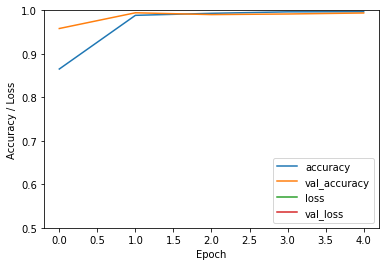

In [ ]:
history = model3.fit(train_images, train_labels, epochs=5, batch_size=64,
                    validation_data=(test_images, test_labels))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model3.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

## Saving the Model & Model Weights

In [ ]:
model3.save('/content/drive/MyDrive/model_glasses', save_format='h5')
model3.save_weights('/content/drive/MyDrive/model_glasses_weights', save_format='h5')

## Visualise Prediction

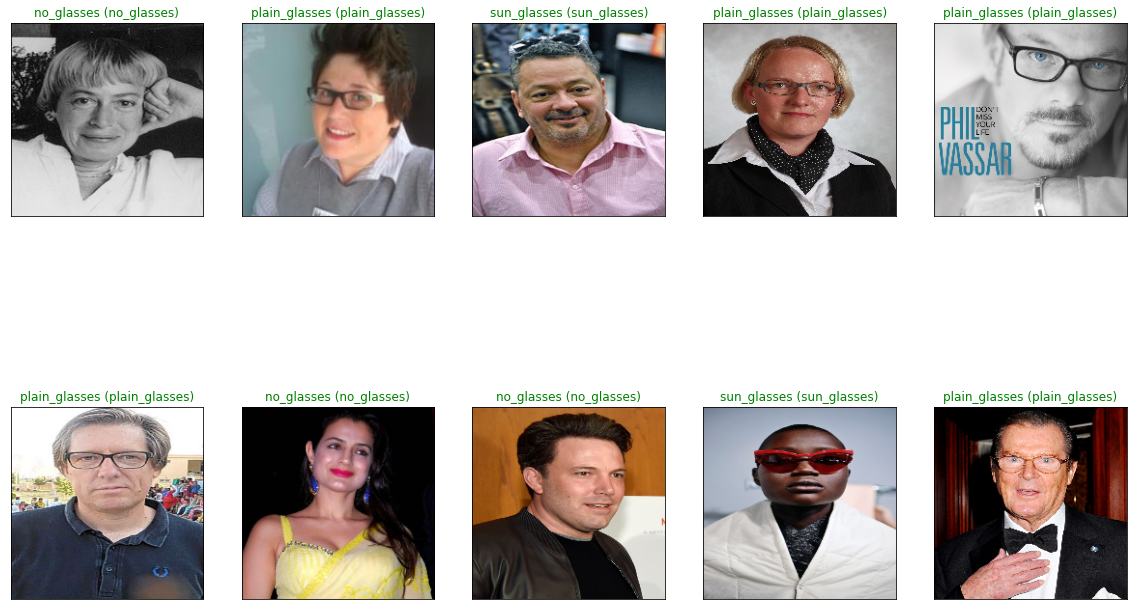

In [ ]:
# Visualising the prediction of random 10 images from testing data
figure = plt.figure(figsize=(20, 20))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = test_labels[index]
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Evaluation Metrics

In [ ]:
# Calculating metrics
y_hat = model3.predict(test_images)
y_pred = np.argmax(y_hat, axis=1)

print('\n Classification Report: \n',(classification_report(test_labels, y_pred)))
print('\n Accuracy Score: {:.4f}'.format(accuracy_score(test_labels, y_pred)))
print('\n Precision Score: {:.4f}'.format(precision_score(test_labels, y_pred , average="macro")))
print('\n Recall Score: {:.4f}'.format(recall_score(test_labels, y_pred , average="macro")))
print('\n Confusion Matrix \n {}' .format(confusion_matrix(test_labels, y_pred )))
print('\n f1_score: {:.4f}'.format(f1_score(test_labels, y_pred , average="macro")))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       800
           1       0.99      0.99      0.99       776
           2       1.00      1.00      1.00       580

    accuracy                           0.99      2156
   macro avg       0.99      0.99      0.99      2156
weighted avg       0.99      0.99      0.99      2156


 Accuracy Score: 0.9940

 Precision Score: 0.9942

 Recall Score: 0.9945

 Confusion Matrix 
 [[791   7   2]
 [  4 772   0]
 [  0   0 580]]

 f1_score: 0.9944


# Model 4 - hair colour

## Combining images & labels

In [ ]:
df_hair_color = pd.DataFrame()
df_hair_color['images'] = all_images
labels = labels_df['hair_color'].copy()
df_hair_color['labels'] = labels.values

df_hair_color1 = pd.DataFrame()
df_hair_color1['images'] = all_images1
labels1 = labels_df1['hair_color'].copy()
df_hair_color1['labels'] = labels1.values

In [ ]:
#Count of classes (0 -8)
df = df_hair_color.append(df_hair_color1)
df['labels'].value_counts()

1    1041
0     963
3     590
8     407
2     227
6     156
5     132
4     127
7      80
Name: labels, dtype: int64

## Data Balancing - Over Sampling the classes that has less data



In [ ]:
df_brown = df[df['labels']==0]
df_black = df[df['labels']==1]
df_gray = df[df['labels']==2]
df_blonde = df[df['labels']==3]
df_red = df[df['labels']==4]
df_white = df[df['labels']==5]
df_mixed = df[df['labels']==6]
df_others = df[df['labels']==7]
df_not_visible = df[df['labels']==8]

df_sampling_hair_color = pd.DataFrame(df_brown.iloc[:].append(df_black.iloc[:]))
for i in range(3):
  df_sampling_hair_color = df_sampling_hair_color.append(df_gray)
for i in range(1):
  df_sampling_hair_color = df_sampling_hair_color.append(df_blonde)
  df_sampling_hair_color = df_sampling_hair_color.append(df_blonde.iloc[:200])
for i in range(5):
  df_sampling_hair_color = df_sampling_hair_color.append(df_red)
for i in range(5):
  df_sampling_hair_color = df_sampling_hair_color.append(df_white)
for i in range(2):
  df_sampling_hair_color = df_sampling_hair_color.append(df_mixed)
for i in range(6):
  df_sampling_hair_color = df_sampling_hair_color.append(df_others)
for i in range(1):
  df_sampling_hair_color = df_sampling_hair_color.append(df_not_visible)

In [ ]:
#Count of Classes after sampling - data balancing
df_sampling_hair_color['labels'].value_counts()

1    1041
0     963
3     790
2     681
5     660
4     635
7     480
8     407
6     312
Name: labels, dtype: int64

In [ ]:
X = np.array(df_sampling_hair_color['images'])
y = np.array(df_sampling_hair_color['labels'])
a =[]
for i in range(len(X)):
  a.append(X[i])
X = np.array(a)
X.shape

(5969, 200, 200, 3)

## Data samples before and after balancing

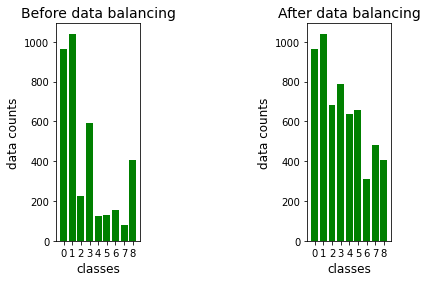

In [ ]:
plt.subplot(1, 2, 1)
plt.bar(df['labels'].value_counts().index,df['labels'].value_counts(), align='center',  color = 'green')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.xlabel('classes', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('Before data balancing', fontsize=14)
plt.subplots_adjust(wspace = 1.5, hspace = 1.5)

plt.subplot(1, 2, 2)
plt.bar(df_sampling_hair_color['labels'].value_counts().index,df_sampling_hair_color['labels'].value_counts(), align='center',  color = 'green')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.xlabel('classes', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('After data balancing', fontsize=14)
plt.subplots_adjust(wspace = 2, hspace = 2)

plt.show()

## Label Encoding

In [ ]:
y_encode = LabelEncoder()
y = y_encode.fit_transform(y)

## Split train and test images



In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=142, stratify=y)

In [ ]:
print(f'Shape of the training data: {train_images.shape}')
print(f'Shape of the training target: {train_labels.shape}')
print(f'Shape of the test data: {test_images.shape}')
print(f'Shape of the test target: {test_labels.shape}')

Shape of the training data: (4775, 200, 200, 3)
Shape of the training target: (4775,)
Shape of the test data: (1194, 200, 200, 3)
Shape of the test target: (1194,)


In [ ]:
#Count of the classes in training dataset
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([770, 833, 545, 632, 508, 528, 250, 384, 325]))

In [ ]:
#Count of the classes in testing dataset
np.unique(test_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([193, 208, 136, 158, 127, 132,  62,  96,  82]))

## Verify few images from training dataset

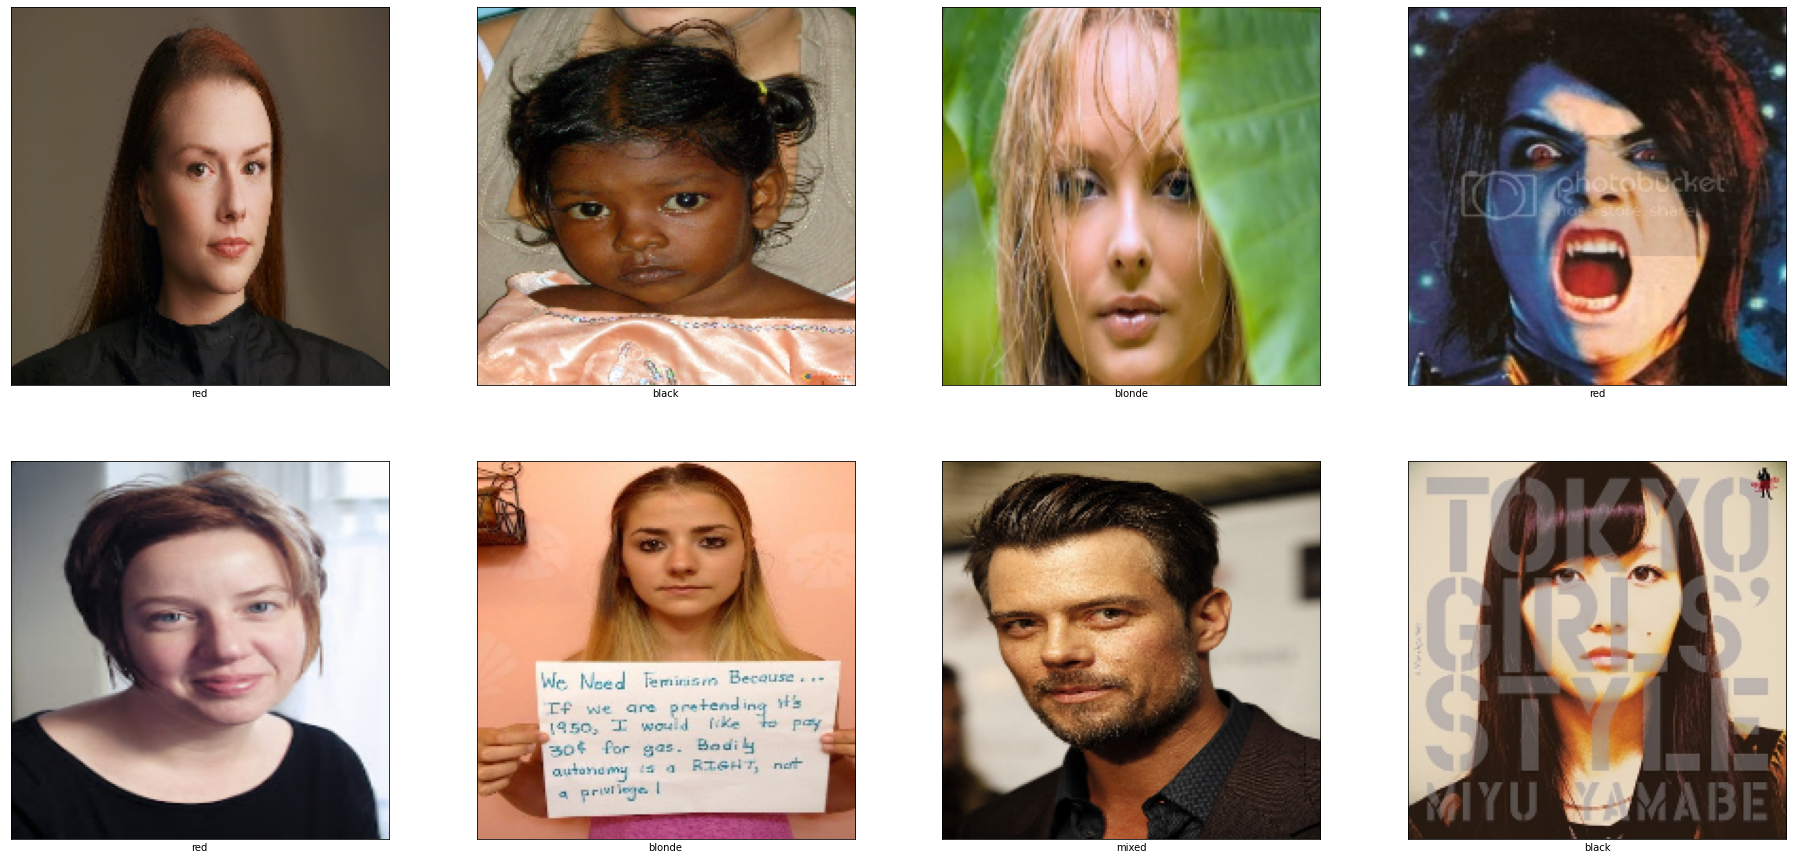

In [ ]:
# To verify if the dataset is correct and labels are matching the images
class_names = ['brown', 'black', 'gray', 'blonde', 'red', 'white', 'mixed', 'others', 'not visible']

plt.figure(figsize=(32,32))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Normalization of images

In [ ]:
# Normalizing
train_images, test_images = train_images / 255.0, test_images / 255.0

## Using DenseNet and train the model

In [ ]:
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.1),
        preprocessing.RandomZoom(0.2)
    ]
)
input_shape = (200, 200, 3)
inputs = keras.Input(shape=input_shape)

# Augment images
x = data_augmentation(inputs)

model4 = keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=input_shape)(x)

# add output layer
flat1 = layers.Flatten()(model4)
dropout1 = layers.Dropout(0.2)(flat1)
outputs = layers.Dense(9, activation='softmax')(flat1)

# define new model
model4 = Model(inputs=inputs, outputs= outputs)

model4.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model4.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential_34 (Sequential)   (None, 200, 200, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten_34 (Flatten)         (None, 59904)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 9)                 539145    
Total params: 13,182,025
Trainable params: 13,023,625
Non-trainable params: 158,400
_________________________________________________________________


## Training

Epoch 1/7
75/75 [==============================] - 50s 421ms/step - loss: 2.2868 - accuracy: 0.3101 - val_loss: 1.6823 - val_accuracy: 0.5101
Epoch 2/7
75/75 [==============================] - 28s 379ms/step - loss: 1.2047 - accuracy: 0.5919 - val_loss: 1.6614 - val_accuracy: 0.5511
Epoch 3/7
75/75 [==============================] - 28s 380ms/step - loss: 0.8578 - accuracy: 0.7133 - val_loss: 1.1926 - val_accuracy: 0.6558
Epoch 4/7
75/75 [==============================] - 28s 380ms/step - loss: 0.7237 - accuracy: 0.7460 - val_loss: 1.0886 - val_accuracy: 0.6750
Epoch 5/7
75/75 [==============================] - 28s 380ms/step - loss: 0.5129 - accuracy: 0.8214 - val_loss: 0.9352 - val_accuracy: 0.7069
Epoch 6/7
75/75 [==============================] - 28s 379ms/step - loss: 0.4071 - accuracy: 0.8530 - val_loss: 0.9127 - val_accuracy: 0.7002
Epoch 7/7
75/75 [==============================] - 28s 379ms/step - loss: 0.3166 - accuracy: 0.8988 - val_loss: 0.8360 - val_accuracy: 0.7446
38/38 

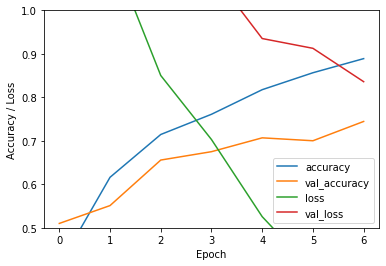

In [ ]:
history = model4.fit(train_images, train_labels, epochs=7, batch_size=64,
                    validation_data=(test_images, test_labels))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model4.evaluate(test_images,  test_labels, verbose=2)

## Saving the model

In [ ]:
model4.save('/content/drive/MyDrive/model_haircolor3', save_format='h5')
model4.save_weights('/content/drive/MyDrive/model_haircolor_weights3', save_format='h5')
# Calculating metrics

## Visualise Prediction on Test Dataset

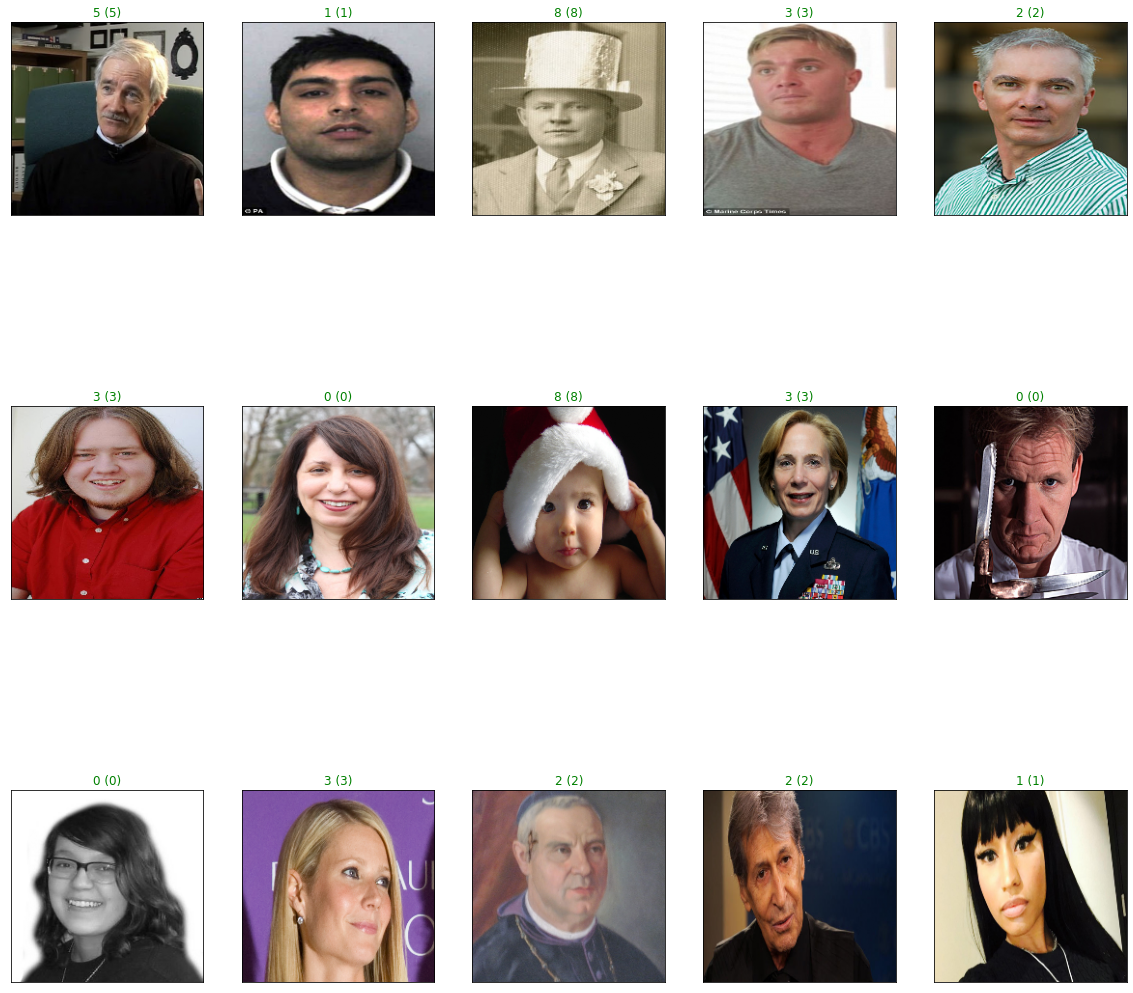

In [ ]:
import pdb
y_hat = model4.predict(test_images)

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 20))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(predict_index, 
                                  true_index),
                                  color=("green" if predict_index == true_index else "red"))

## Evaluation Metrics

In [ ]:
# Calculating metrics

y_hat = model4.predict(test_images)
y_pred = np.argmax(y_hat, axis=1)

print('\n Classification Report:\n',classification_report(test_labels, y_pred))
print('\n Accuracy Score: {:.4f}'.format(accuracy_score(test_labels, y_pred)))
print('\n Precision Score: {:.4f}'.format(precision_score(test_labels, y_pred , average="macro")))
print('\n Recall Score: {:.4f}'.format(recall_score(test_labels, y_pred , average="macro")))
print('\n f1_score: {:.4f}'.format(f1_score(test_labels, y_pred , average="macro")))
print('\n Confusion Matrix: \n {}' .format(confusion_matrix(test_labels, y_pred )))



 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.36      0.49       193
           1       0.64      0.71      0.67       208
           2       0.87      0.87      0.87       136
           3       0.67      0.87      0.76       158
           4       0.90      0.94      0.92       127
           5       0.94      0.90      0.92       132
           6       0.58      0.68      0.63        62
           7       0.90      0.95      0.92        96
           8       0.46      0.56      0.51        82

    accuracy                           0.74      1194
   macro avg       0.75      0.76      0.74      1194
weighted avg       0.75      0.74      0.74      1194


 Accuracy Score: 0.7446

 Precision Score: 0.7464

 Recall Score: 0.7588

 f1_score: 0.7427

 Confusion Matrix: 
 [[ 70  48   3  44   6   0  10   5   7]
 [ 17 147   5   3   2   0  10   1  23]
 [  2   5 118   5   0   1   0   1   4]
 [  3   3   4 137   3   1   3   2   2

# Model 5 - hair top

## Combining images & labels

In [ ]:
df_hair_top = pd.DataFrame()
df_hair_top['images'] = all_images
labels = labels_df['hair_top'].copy()
df_hair_top['labels'] = labels.values

df_hair_top1 = pd.DataFrame()
df_hair_top1['images'] = all_images1
labels1 = labels_df1['hair_top'].copy()
df_hair_top1['labels'] = labels1.values

In [ ]:
#Count of classes (0 - no hair/bald, 1 - less hair, 2 - thick hair, 3 - not visible)
df = df_hair_top.append(df_hair_top1)
df['labels'].value_counts()

2    2565
3     703
1     350
0     105
Name: labels, dtype: int64

## Data Balancing - Over Sampling the classes that has less data



In [ ]:
df_no_hair = df[df['labels']==0]
df_less_hair = df[df['labels']==1]
df_thick_hair= df[df['labels']==2]
df_not_visible = df[df['labels']==3]

df_sampling_hair_top = pd.DataFrame()
for i in range(17):
  df_sampling_hair_top = df_sampling_hair_top.append(df_no_hair)
for i in range(5):
  df_sampling_hair_top = df_sampling_hair_top.append(df_less_hair)
for i in range(1):
  df_sampling_hair_top = df_sampling_hair_top.append(df_thick_hair.iloc[:])
for i in range(1):
  df_sampling_hair_top = df_sampling_hair_top.append(df_not_visible)


In [ ]:
df_sampling_hair_top['labels'].value_counts()

2    2565
0    1785
1    1750
3     703
Name: labels, dtype: int64

In [ ]:
X = np.array(df_sampling_hair_top['images'])
y = np.array(df_sampling_hair_top['labels'])
a =[]
for i in range(len(X)):
  a.append(X[i])
X = np.array(a)
X.shape

(6803, 200, 200, 3)

## Data samples before and after balancing

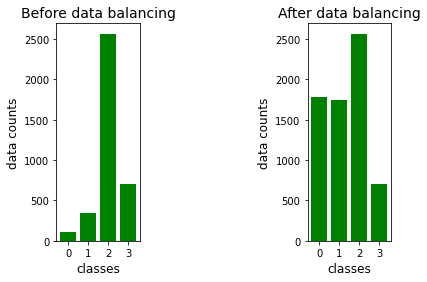

In [ ]:
plt.subplot(1, 2, 1)
plt.bar(df['labels'].value_counts().index,df['labels'].value_counts(), align='center',  color = 'green')
plt.xticks([0, 1, 2, 3])
plt.xlabel('classes', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('Before data balancing', fontsize=14)
plt.subplots_adjust(wspace = 1.5, hspace = 1.5)

plt.subplot(1, 2, 2)
plt.bar(df_sampling_hair_top['labels'].value_counts().index,df_sampling_hair_top['labels'].value_counts(), align='center',  color = 'green')
plt.xticks([0, 1, 2, 3])
plt.xlabel('classes', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('After data balancing', fontsize=14)
plt.subplots_adjust(wspace = 2, hspace = 2)

plt.show()

## Label Encoding

In [ ]:
y_encode = LabelEncoder()
y = y_encode.fit(y)
y = y_encode.transform(y)

array([0, 0, 0, ..., 3, 3, 3])

## Split train and test images



In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
print(f'Shape of the training data: {train_images.shape}')
print(f'Shape of the training target: {train_labels.shape}')
print(f'Shape of the test data: {test_images.shape}')
print(f'Shape of the test target: {test_labels.shape}')

Shape of the training data: (4762, 200, 200, 3)
Shape of the training target: (4762,)
Shape of the test data: (2041, 200, 200, 3)
Shape of the test target: (2041,)


In [ ]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3]), array([1250, 1225, 1795,  492]))

In [ ]:
np.unique(test_labels, return_counts=True)

(array([0, 1, 2, 3]), array([535, 525, 770, 211]))

## Verify few images from training set

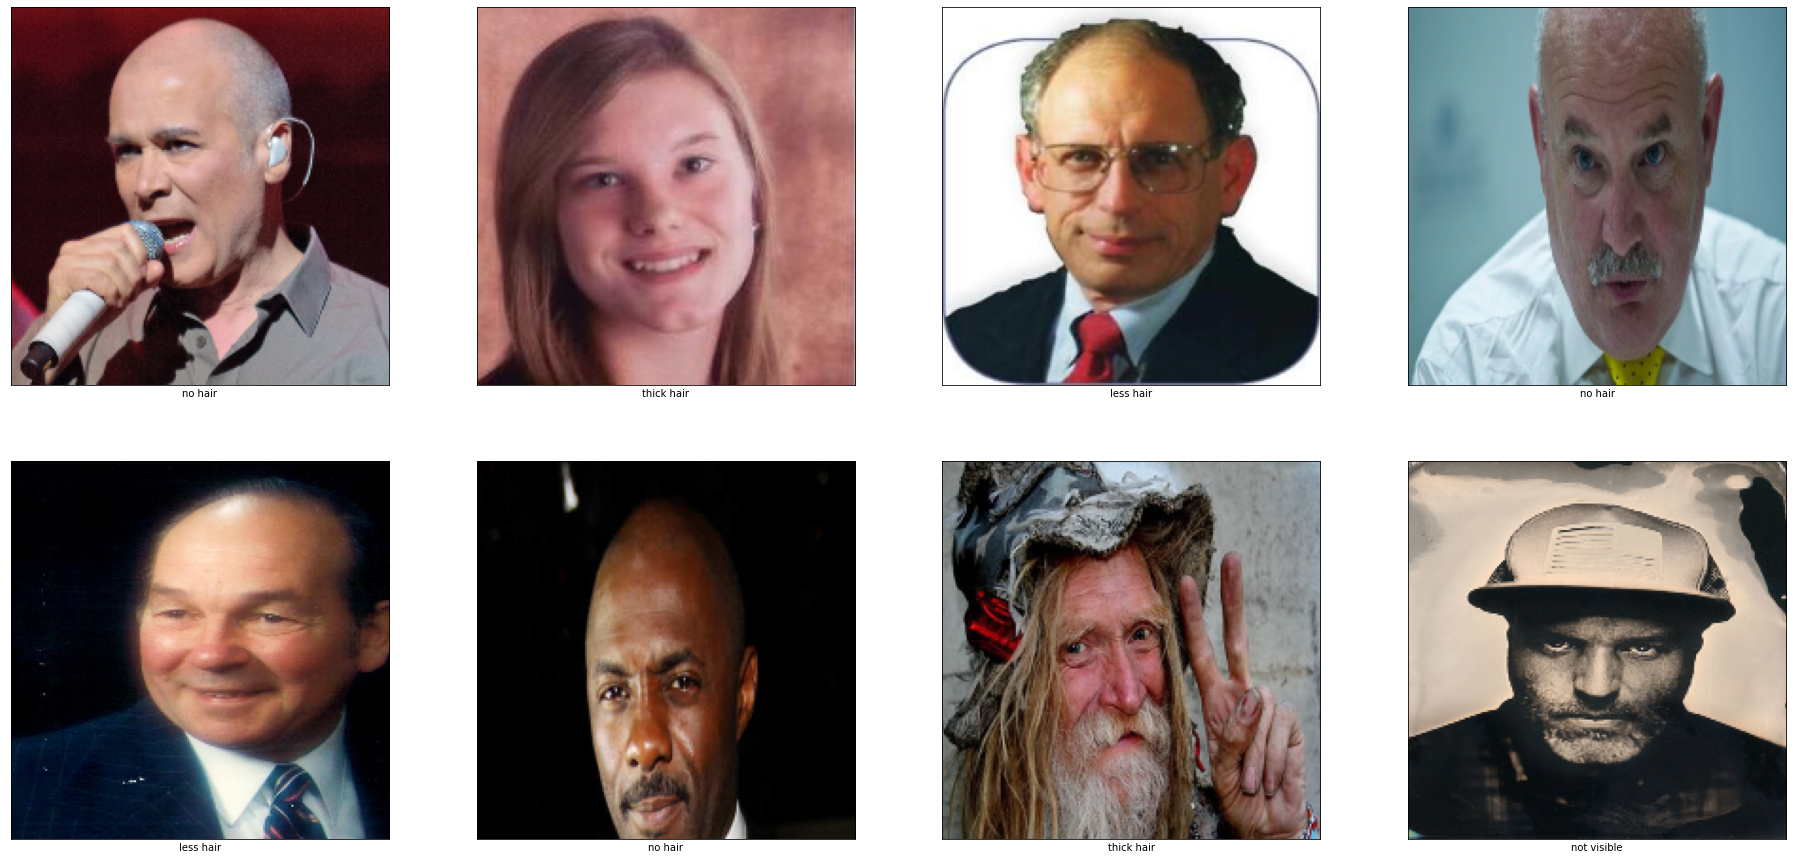

In [ ]:
# To verify if the dataset is correct and labels are matching the images
class_names = ['no hair', 'less hair', 'thick hair', 'not visible']

plt.figure(figsize=(32,32))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Normalisation of images

In [ ]:
# Normalizing
train_images, test_images = train_images / 255.0, test_images / 255.0

## Using DenseNet and train the model

In [ ]:
#Data Augmentation
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomContrast(0.1),
        preprocessing.RandomContrast(0.2),
        preprocessing.RandomZoom(0.1),
        preprocessing.RandomRotation(0.1)
    ]
)
input_shape = (200, 200, 3)
inputs = keras.Input(shape=input_shape)

x = data_augmentation(inputs)

model5 = keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=input_shape)(x)

# adding output layer
flat1 = layers.Flatten()(model5)
outputs = layers.Dense(4, activation='softmax')(flat1)

# define new model
model5 = Model(inputs=inputs, outputs= outputs)

model5.compile(optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model5.summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential_53 (Sequential)   (None, 200, 200, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten_53 (Flatten)         (None, 59904)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 239620    
Total params: 12,882,500
Trainable params: 12,724,100
Non-trainable params: 158,400
_________________________________________________________________


## Training

Epoch 1/10
75/75 [==============================] - 47s 448ms/step - loss: 1.4590 - accuracy: 0.4176 - val_loss: 1.0178 - val_accuracy: 0.5835
Epoch 2/10
75/75 [==============================] - 30s 395ms/step - loss: 0.7950 - accuracy: 0.6912 - val_loss: 0.7040 - val_accuracy: 0.7315
Epoch 3/10
75/75 [==============================] - 30s 395ms/step - loss: 0.5797 - accuracy: 0.7828 - val_loss: 0.6069 - val_accuracy: 0.7736
Epoch 4/10
75/75 [==============================] - 30s 395ms/step - loss: 0.4457 - accuracy: 0.8372 - val_loss: 0.4885 - val_accuracy: 0.8310
Epoch 5/10
75/75 [==============================] - 30s 395ms/step - loss: 0.3611 - accuracy: 0.8755 - val_loss: 0.4129 - val_accuracy: 0.8584
Epoch 6/10
75/75 [==============================] - 30s 395ms/step - loss: 0.3195 - accuracy: 0.8906 - val_loss: 0.3790 - val_accuracy: 0.8765
Epoch 7/10
75/75 [==============================] - 30s 395ms/step - loss: 0.2740 - accuracy: 0.9078 - val_loss: 0.3409 - val_accuracy: 0.8863

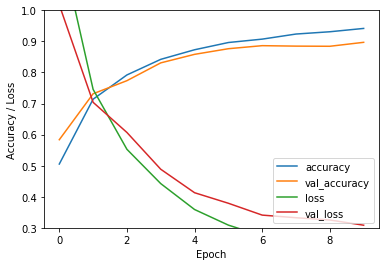

In [ ]:
history = model5.fit(train_images, train_labels, epochs=10, batch_size=64,
                    validation_data=(test_images, test_labels))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model5.evaluate(test_images,  test_labels, verbose=2)

## Saving the model

In [ ]:
model5.save('/content/drive/MyDrive/model_hairtop', save_format='h5')
model5.save_weights('/content/drive/MyDrive/model_hairtop_weights', save_format='h5')

## Visualise Prediction

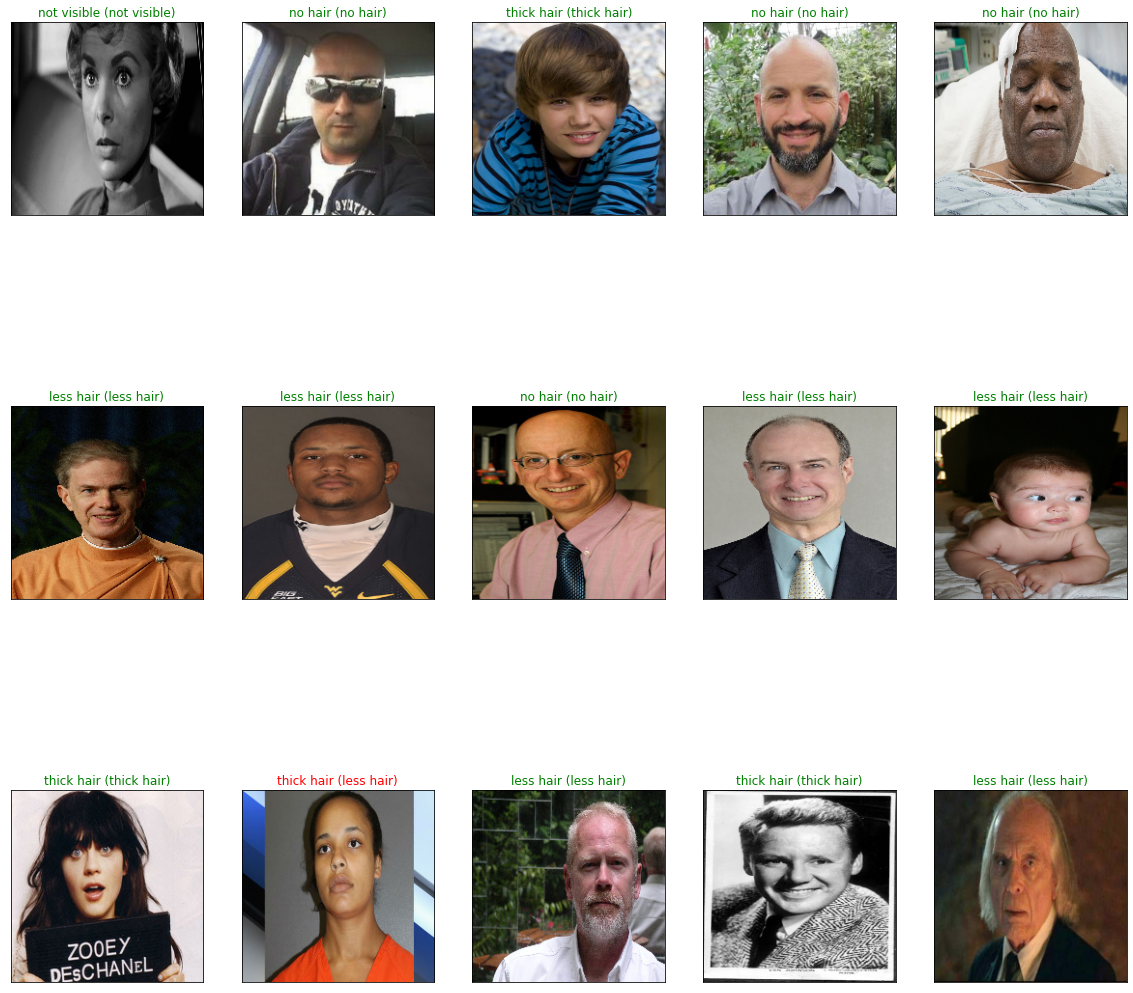

In [ ]:
import pdb
y_hat = model5.predict(test_images)

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 20))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Evaluation Metrics

In [ ]:
# Calculating metrics

y_pred = np.argmax(y_hat, axis=1)

print('\n Classification Report:\n',classification_report(test_labels, y_pred))
print('\n Accuracy Score: {:.4f}'.format(accuracy_score(test_labels, y_pred)))
print('\n Precision Score: {:.4f}'.format(precision_score(test_labels, y_pred , average="macro")))
print('\n Recall Score: {:.4f}'.format(recall_score(test_labels, y_pred , average="macro")))
print('\n f1_score: {:.4f}'.format(f1_score(test_labels, y_pred , average="macro")))
print('\n Confusion Matrix: \n {}' .format(confusion_matrix(test_labels, y_pred )))


 Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       535
           1       0.88      0.96      0.92       525
           2       0.89      0.86      0.88       770
           3       0.71      0.59      0.64       211

    accuracy                           0.90      2041
   macro avg       0.87      0.85      0.86      2041
weighted avg       0.89      0.90      0.89      2041


 Accuracy Score: 0.8971

 Precision Score: 0.8655

 Recall Score: 0.8541

 f1_score: 0.8578

 Confusion Matrix: 
 [[535   0   0   0]
 [  4 506  14   1]
 [  2  52 666  50]
 [  7  15  65 124]]
